##### Copyright 2022 The TensorFlow Authors.

In [1]:
# Copyright 2023 The TensorFlow Authors. All Rights Reserved.
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MLMD Model Card Toolkit Demo

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/responsible_ai/model_card_toolkit/examples/MLMD_Model_Card_Toolkit_Demo"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/documentation/examples/MLMD_Model_Card_Toolkit_Demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/documentation/examples/MLMD_Model_Card_Toolkit_Demo.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/model-card-toolkit/model_card_toolkit/documentation/examples/MLMD_Model_Card_Toolkit_Demo.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Background

This notebook demonstrates how to generate a model card using the Model Card Toolkit with MLMD and TFX pipeline in a Jupyter/Colab environment. You can learn more about model cards at https://modelcards.withgoogle.com/about. 



## Setup
We first need to a) install and import the necessary packages, and b) download the data.

### Upgrade to Pip 21 (or later) and Install Model Card Toolkit

In [2]:
# %pip install --upgrade pip
# %pip install tfx-addons[model-card-toolkit]

####*Did you restart the runtime?*

If you are using Google Colab, the runtime must be restarted after installing new packages.

### Import packages

We import necessary packages, including standard TFX component classes and check the library versions.


In [3]:
import os
import tempfile
import urllib

import absl
import json
import tensorflow as tf
import tensorflow_model_analysis as tfma
import tfx.v1 as tfx
import tfx_addons as tfxa
import ml_metadata as mlmd
import model_card_toolkit as mct

from tfx.components import CsvExampleGen
from tfx.components import Evaluator
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.components.base import executor_spec
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import example_gen_pb2
from tfx.proto import trainer_pb2

from tfx_addons.model_card_generator.component import ModelCardGenerator

In [4]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))
print('TFX Addons version: {}'.format(tfxa.__version__))
print('MLMD version: {}'.format(mlmd.__version__))
print('Model Card Toolkit version: {}'.format(mct.__version__))


TensorFlow version: 2.11.1
TFX version: 1.12.0
TFX Addons version: 0.4.0-dev
MLMD version: 1.12.0
Model Card Toolkit version: 2.0.0


### Set up pipeline paths

In [5]:
# This is the root directory for your TFX pip package installation.
# _tfx_root = tfx.__path__

# Set up logging.
absl.logging.set_verbosity(absl.logging.INFO)

### Download example data
We download the example dataset for use in our TFX pipeline.


In [6]:
DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/' \
   'adult.data'
_data_root = tempfile.mkdtemp(prefix='tfx-data')
_data_filepath = os.path.join(_data_root, "data.csv")
urllib.request.urlretrieve(DATA_PATH, _data_filepath)

columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]

with open(_data_filepath, 'r') as f:
  content = f.read()
  content = content.replace(", <=50K", ', 0').replace(", >50K", ', 1')

with open(_data_filepath, 'w') as f:
  f.write(','.join(columns) + '\n' + content)

Take a quick look at the CSV file.

In [7]:
!head {_data_filepath}

Age,Workclass,fnlwgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-week,Country,Over-50K
39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, 0
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, 0
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, 0
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, 0
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, 0
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, 0
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0, 16, Jamaica, 0
52, Self-emp

### Create the InteractiveContext
Last, we create an InteractiveContext, which will allow us to run TFX components interactively in this notebook.

In [8]:
# Here, we create an InteractiveContext using default parameters. This will
# use a temporary directory with an ephemeral ML Metadata database instance.
# To use your own pipeline root or database, the optional properties
# `pipeline_root` and `metadata_connection_config` may be passed to
# InteractiveContext. Calls to InteractiveContext are no-ops outside of the
# notebook.
context = InteractiveContext(pipeline_name="Census Income Classification Pipeline")

## Run TFX components interactively
In the cells that follow, we create TFX components one-by-one, run each of them, and visualize their output artifacts. In this notebook, we won’t provide detailed explanations of each TFX component, but you can see what each does at [TFX Colab workshop](https://github.com/tensorflow/workshops/blob/master/tfx_labs/Lab_1_Pipeline_in_Colab.ipynb).

### ExampleGen

Create the `ExampleGen` component to split data into training and evaluation sets, convert the data into `tf.Example` format, and copy data into the `_tfx_root` directory for other components to access. 

In [9]:
output = tfx.proto.Output(
             split_config=example_gen_pb2.SplitConfig(splits=[
                 tfx.proto.SplitConfig.Split(name='train', hash_buckets=9),
                 tfx.proto.SplitConfig.Split(name='eval', hash_buckets=1)
             ]))

example_gen = CsvExampleGen(input_base=_data_root, output_config=output)
context.run(example_gen)

INFO:absl:Running driver for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:select span and version = (0, None)
INFO:absl:latest span and version = (0, None)
INFO:absl:Running executor for CsvExampleGen
INFO:absl:Generating examples.


INFO:absl:Processing input csv data /tmp/tfx-datatpwerxc8/* to TFExample.
INFO:absl:Examples generated.
INFO:absl:Running publisher for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

In [10]:
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval"] /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/CsvExampleGen/examples/1


Let’s take a look at the first three training examples:

In [11]:
# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 3 records and decode them.
for tfrecord in dataset.take(3):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  print(example)

features {
  feature {
    key: "Age"
    value {
      int64_list {
        value: 39
      }
    }
  }
  feature {
    key: "Capital-Gain"
    value {
      int64_list {
        value: 2174
      }
    }
  }
  feature {
    key: "Capital-Loss"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "Country"
    value {
      bytes_list {
        value: " United-States"
      }
    }
  }
  feature {
    key: "Education"
    value {
      bytes_list {
        value: " Bachelors"
      }
    }
  }
  feature {
    key: "Education-Num"
    value {
      int64_list {
        value: 13
      }
    }
  }
  feature {
    key: "Hours-per-week"
    value {
      int64_list {
        value: 40
      }
    }
  }
  feature {
    key: "Marital-Status"
    value {
      bytes_list {
        value: " Never-married"
      }
    }
  }
  feature {
    key: "Occupation"
    value {
      bytes_list {
        value: " Adm-clerical"
      }
    }
  }
  feature {
    key: "Ov

### StatisticsGen

`StatisticsGen` takes as input the dataset we just ingested using `ExampleGen` and allows you to perform some analysis of your dataset using TensorFlow Data Validation (TFDV).

In [12]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])
context.run(statistics_gen)

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Running driver for StatisticsGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for StatisticsGen
INFO:absl:Generating statistics for split train.
INFO:absl:Statistics for split train written to /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/StatisticsGen/statistics/2/Split-train.
INFO:absl:Generating statistics for split eval.
INFO:absl:Statistics for split eval written to /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/StatisticsGen/statistics/2/Split-eval.
INFO:absl:Running publisher for StatisticsGen
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

After `StatisticsGen` finishes running, we can visualize the outputted statistics. Try playing with the different plots!

In [13]:
context.show(statistics_gen.outputs['statistics'])

### SchemaGen

`SchemaGen` will take as input the statistics that we generated with `StatisticsGen`, looking at the training split by default.

In [14]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False)
context.run(schema_gen)

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Running driver for SchemaGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for SchemaGen
INFO:absl:Processing schema from statistics for split train.
INFO:absl:Processing schema from statistics for split eval.
INFO:absl:Schema written to /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/SchemaGen/schema/3/schema.pbtxt.
INFO:absl:Running publisher for SchemaGen
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}))

In [15]:
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'Age',INT,required,single,-
'Capital-Gain',INT,required,single,-
'Capital-Loss',INT,required,single,-
'Country',STRING,required,single,'Country'
'Education',STRING,required,single,'Education'
'Education-Num',INT,required,single,-
'Hours-per-week',INT,required,single,-
'Marital-Status',STRING,required,single,'Marital-Status'
'Occupation',STRING,required,single,'Occupation'


,Values
Domain,
'Country',"' ?', ' Cambodia', ' Canada', ' China', ' Columbia', ' Cuba', ' Dominican-Republic', ' Ecuador', ' El-Salvador', ' England', ' France', ' Germany', ' Greece', ' Guatemala', ' Haiti', ' Holand-Netherlands', ' Honduras', ' Hong', ' Hungary', ' India', ' Iran', ' Ireland', ' Italy', ' Jamaica', ' Japan', ' Laos', ' Mexico', ' Nicaragua', ' Outlying-US(Guam-USVI-etc)', ' Peru', ' Philippines', ' Poland', ' Portugal', ' Puerto-Rico', ' Scotland', ' South', ' Taiwan', ' Thailand', ' Trinadad&Tobago', ' United-States', ' Vietnam', ' Yugoslavia'"
'Education',"' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college'"
'Marital-Status',"' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed'"
'Occupation',"' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving'"
'Race',"' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other', ' White'"
'Relationship',"' Husband', ' Not-in-family', ' Other-relative', ' Own-child', ' Unmarried', ' Wife'"
'Sex',"' Female', ' Male'"
'Workclass',"' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ' Private', ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'"


To learn more about schemas, see [the SchemaGen documentation](https://www.tensorflow.org/tfx/guide/schemagen).

### Transform

`Transform` will take as input the data from `ExampleGen`, the schema from `SchemaGen`, as well as a module that contains user-defined Transform code.

Let's see an example of user-defined Transform code below (for an introduction to the TensorFlow Transform APIs, [see the tutorial](https://www.tensorflow.org/tfx/tutorials/transform/simple)).



In [16]:
_census_income_constants_module_file = 'census_income_constants.py'

In [17]:
%%writefile {_census_income_constants_module_file}

# Categorical features are assumed to each have a maximum value in the dataset.
MAX_CATEGORICAL_FEATURE_VALUES = [20]

CATEGORICAL_FEATURE_KEYS = ["Education-Num"]


DENSE_FLOAT_FEATURE_KEYS = ["Capital-Gain", "Hours-per-week", "Capital-Loss"]

# Number of buckets used by tf.transform for encoding each feature.
FEATURE_BUCKET_COUNT = 10

BUCKET_FEATURE_KEYS = ["Age"]

# Number of vocabulary terms used for encoding VOCAB_FEATURES by tf.transform
VOCAB_SIZE = 200

# Count of out-of-vocab buckets in which unrecognized VOCAB_FEATURES are hashed.
OOV_SIZE = 10

VOCAB_FEATURE_KEYS = ["Workclass", "Education", "Marital-Status", "Occupation", 
                      "Relationship", "Race", "Sex", "Country"]

# Keys
LABEL_KEY = "Over-50K"

def transformed_name(key):
  return key + '_xf'

Overwriting census_income_constants.py


In [18]:
_census_income_transform_module_file = 'census_income_transform.py'

In [19]:
%%writefile {_census_income_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

import census_income_constants

_DENSE_FLOAT_FEATURE_KEYS = census_income_constants.DENSE_FLOAT_FEATURE_KEYS
_VOCAB_FEATURE_KEYS = census_income_constants.VOCAB_FEATURE_KEYS
_VOCAB_SIZE = census_income_constants.VOCAB_SIZE
_OOV_SIZE = census_income_constants.OOV_SIZE
_FEATURE_BUCKET_COUNT = census_income_constants.FEATURE_BUCKET_COUNT
_BUCKET_FEATURE_KEYS = census_income_constants.BUCKET_FEATURE_KEYS
_CATEGORICAL_FEATURE_KEYS = census_income_constants.CATEGORICAL_FEATURE_KEYS
_LABEL_KEY = census_income_constants.LABEL_KEY
_transformed_name = census_income_constants.transformed_name


def preprocessing_fn(inputs):
  """tf.transform's callback function for preprocessing inputs.
  Args:
    inputs: map from feature keys to raw not-yet-transformed features.
  Returns:
    Map from string feature key to transformed feature operations.
  """
  outputs = {}
  for key in _DENSE_FLOAT_FEATURE_KEYS:
    # Preserve this feature as a dense float, setting nan's to the mean.
    outputs[_transformed_name(key)] = tft.scale_to_z_score(
        _fill_in_missing(inputs[key]))

  for key in _VOCAB_FEATURE_KEYS:
    # Build a vocabulary for this feature.
    outputs[_transformed_name(key)] = tft.compute_and_apply_vocabulary(
        _fill_in_missing(inputs[key]),
        top_k=_VOCAB_SIZE,
        num_oov_buckets=_OOV_SIZE)

  for key in _BUCKET_FEATURE_KEYS:
    outputs[_transformed_name(key)] = tft.bucketize(
        _fill_in_missing(inputs[key]), _FEATURE_BUCKET_COUNT)

  for key in _CATEGORICAL_FEATURE_KEYS:
    outputs[_transformed_name(key)] = _fill_in_missing(inputs[key])

  label = _fill_in_missing(inputs[_LABEL_KEY])
  outputs[_transformed_name(_LABEL_KEY)] = label
  
  return outputs


def _fill_in_missing(x):
  """Replace missing values in a SparseTensor.
  Fills in missing values of `x` with '' or 0, and converts to a dense tensor.
  Args:
    x: A `SparseTensor` of rank 2.  Its dense shape should have size at most 1
      in the second dimension.
  Returns:
    A rank 1 tensor where missing values of `x` have been filled in.
  """
  default_value = '' if x.dtype == tf.string else 0
  return tf.squeeze(
      tf.sparse.to_dense(
          tf.SparseTensor(x.indices, x.values, [x.dense_shape[0], 1]),
          default_value),
      axis=1)

Overwriting census_income_transform.py


In [20]:
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_census_income_transform_module_file))
context.run(transform)

INFO:absl:Generating ephemeral wheel package for '/home/hannes/tfx-addons/examples/model_card_generator/census_income_transform.py' (including modules: ['census_income_trainer', 'census_income_constants', 'census_income_transform']).
INFO:absl:User module package has hash fingerprint version aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe.
INFO:absl:Executing: ['/bin/python3', '/tmp/tmpb107nej5/_tfx_generated_setup.py', 'bdist_wheel', '--bdist-dir', '/tmp/tmpbzrqa90p', '--dist-dir', '/tmp/tmprvxg66f3']
INFO:absl:Successfully built user code wheel distribution at '/tmp/tfx-Census Income Classification Pipeline-2_2mej8l/_wheels/tfx_user_code_Transform-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe-py3-none-any.whl'; target user module is 'census_income_transform'.
INFO:absl:Full user module path is 'census_income_transform@/tmp/tfx-Census Income Classification Pipeline-2_2mej8l/_wheels/tfx_user_code_Transform-0.0+aa1f5233b0e0a112365f42ff9488eec93da4

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.
INFO:absl:Feature Age has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Capital-Gain has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Capital-Loss has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Country has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Education has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Education-Num has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Hours-per-week has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Marital-Status has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Occupation has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Over-50K has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Race has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Relationship has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Sex has no shape. Setting to VarLenSparseTensor.
I

INFO:tensorflow:Assets written to: /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/Transform/transform_graph/4/.temp_path/tftransform_tmp/a4dc7527b15548dba3b151b359b24b3e/assets


INFO:tensorflow:Assets written to: /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/Transform/transform_graph/4/.temp_path/tftransform_tmp/a4dc7527b15548dba3b151b359b24b3e/assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.
INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.
INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.
INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.
INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.
INFO:absl:If the number of unique tokens is smaller than the provided top_k or

INFO:tensorflow:Assets written to: /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/Transform/transform_graph/4/.temp_path/tftransform_tmp/2af7cdf70dae420e843627516e16b884/assets


INFO:tensorflow:Assets written to: /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/Transform/transform_graph/4/.temp_path/tftransform_tmp/2af7cdf70dae420e843627516e16b884/assets
INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.
INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.
INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.
INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vo

INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.
INFO:absl:Feature Age_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Capital-Gain_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Capital-Loss_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Country_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Education-Num_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Education_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Hours-per-week_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Marital-Status_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Occupation_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Over-50K_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Race_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Relationship_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Sex_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Workclass_xf has a shape . Sett

INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.
INFO:absl:Feature Age_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Capital-Gain_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Capital-Loss_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Country_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Education-Num_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Education_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Hours-per-week_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Marital-Status_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Occupation_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Over-50K_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Race_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Relationship_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Sex_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature Workclass_xf has a shape . Sett

ExecutionResult(
    component_id: Transform
    execution_id: 4
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={})
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={})
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={})
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={})
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}))

In [21]:
transform.outputs['transform_graph']

OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})

### Trainer
Let's see an example of user-defined model code below (for an introduction to the TensorFlow Keras APIs, [see the tutorial](https://www.tensorflow.org/guide/keras)):

In [22]:
_census_income_trainer_module_file = 'census_income_trainer.py'

In [23]:
%%writefile {_census_income_trainer_module_file}

from typing import List, Text

import os
import absl
import datetime
import tensorflow as tf
import tensorflow_transform as tft

from tfx.components.trainer.executor import TrainerFnArgs

import census_income_constants

_DENSE_FLOAT_FEATURE_KEYS = census_income_constants.DENSE_FLOAT_FEATURE_KEYS
_VOCAB_FEATURE_KEYS = census_income_constants.VOCAB_FEATURE_KEYS
_VOCAB_SIZE = census_income_constants.VOCAB_SIZE
_OOV_SIZE = census_income_constants.OOV_SIZE
_FEATURE_BUCKET_COUNT = census_income_constants.FEATURE_BUCKET_COUNT
_BUCKET_FEATURE_KEYS = census_income_constants.BUCKET_FEATURE_KEYS
_CATEGORICAL_FEATURE_KEYS = census_income_constants.CATEGORICAL_FEATURE_KEYS
_MAX_CATEGORICAL_FEATURE_VALUES = census_income_constants.MAX_CATEGORICAL_FEATURE_VALUES
_LABEL_KEY = census_income_constants.LABEL_KEY
_transformed_name = census_income_constants.transformed_name


def _transformed_names(keys):
  return [_transformed_name(key) for key in keys]


def _gzip_reader_fn(filenames):
  """Small utility returning a record reader that can read gzip'ed files."""
  return tf.data.TFRecordDataset(
      filenames,
      compression_type='GZIP')


def _get_serve_tf_examples_fn(model, tf_transform_output):
  """Returns a function that parses a serialized tf.Example and applies TFT."""

  model.tft_layer = tf_transform_output.transform_features_layer()

  @tf.function
  def serve_tf_examples_fn(serialized_tf_examples):
    """Returns the output to be used in the serving signature."""
    feature_spec = tf_transform_output.raw_feature_spec()
    feature_spec.pop(_LABEL_KEY)
    parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)

    transformed_features = model.tft_layer(parsed_features)
    if _transformed_name(_LABEL_KEY) in transformed_features:
      transformed_features.pop(_transformed_name(_LABEL_KEY))

    return model(transformed_features)

  return serve_tf_examples_fn


def _input_fn(file_pattern: List[Text],
              tf_transform_output: tft.TFTransformOutput,
              batch_size: int = 200) -> tf.data.Dataset:
  """Generates features and label for tuning/training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    tf_transform_output: A TFTransformOutput.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  transformed_feature_spec = (
      tf_transform_output.transformed_feature_spec().copy())

  dataset = tf.data.experimental.make_batched_features_dataset(
      file_pattern=file_pattern,
      batch_size=batch_size,
      features=transformed_feature_spec,
      reader=_gzip_reader_fn,
      label_key=_transformed_name(_LABEL_KEY))

  return dataset


def _build_keras_model(hidden_units: List[int] = None) -> tf.keras.Model:
  """Creates a DNN Keras model.

  Args:
    hidden_units: [int], the layer sizes of the DNN (input layer first).

  Returns:
    A keras Model.
  """
  real_valued_columns = [
      tf.feature_column.numeric_column(key, shape=())
      for key in _transformed_names(_DENSE_FLOAT_FEATURE_KEYS)
  ]
  categorical_columns = [
      tf.feature_column.categorical_column_with_identity(
          key, num_buckets=_VOCAB_SIZE + _OOV_SIZE, default_value=0)
      for key in _transformed_names(_VOCAB_FEATURE_KEYS)
  ]
  categorical_columns += [
      tf.feature_column.categorical_column_with_identity(
          key, num_buckets=_FEATURE_BUCKET_COUNT, default_value=0)
      for key in _transformed_names(_BUCKET_FEATURE_KEYS)
  ]
  categorical_columns += [
      tf.feature_column.categorical_column_with_identity(  # pylint: disable=g-complex-comprehension
          key,
          num_buckets=num_buckets,
          default_value=0) for key, num_buckets in zip(
              _transformed_names(_CATEGORICAL_FEATURE_KEYS),
              _MAX_CATEGORICAL_FEATURE_VALUES)
  ]
  indicator_column = [
      tf.feature_column.indicator_column(categorical_column)
      for categorical_column in categorical_columns
  ]

  model = _wide_and_deep_classifier(
      # TODO(b/139668410) replace with premade wide_and_deep keras model
      wide_columns=indicator_column,
      deep_columns=real_valued_columns,
      dnn_hidden_units=hidden_units or [100, 70, 50, 25])
  return model


def _wide_and_deep_classifier(wide_columns, deep_columns, dnn_hidden_units):
  """Build a simple keras wide and deep model.

  Args:
    wide_columns: Feature columns wrapped in indicator_column for wide (linear)
      part of the model.
    deep_columns: Feature columns for deep part of the model.
    dnn_hidden_units: [int], the layer sizes of the hidden DNN.

  Returns:
    A Wide and Deep Keras model
  """
  # Following values are hard coded for simplicity in this example,
  # However prefarably they should be passsed in as hparams.

  # Keras needs the feature definitions at compile time.
  # TODO(b/139081439): Automate generation of input layers from FeatureColumn.
  input_layers = {
      colname: tf.keras.layers.Input(name=colname, shape=(), dtype=tf.float32)
      for colname in _transformed_names(_DENSE_FLOAT_FEATURE_KEYS)
  }
  input_layers.update({
      colname: tf.keras.layers.Input(name=colname, shape=(), dtype='int32')
      for colname in _transformed_names(_VOCAB_FEATURE_KEYS)
  })
  input_layers.update({
      colname: tf.keras.layers.Input(name=colname, shape=(), dtype='int32')
      for colname in _transformed_names(_BUCKET_FEATURE_KEYS)
  })
  input_layers.update({
      colname: tf.keras.layers.Input(name=colname, shape=(), dtype='int32')
      for colname in _transformed_names(_CATEGORICAL_FEATURE_KEYS)
  })

  # TODO(b/161816639): SparseFeatures for feature columns + Keras.
  deep = tf.keras.layers.DenseFeatures(deep_columns)(input_layers)
  for numnodes in dnn_hidden_units:
    deep = tf.keras.layers.Dense(numnodes)(deep)
  wide = tf.keras.layers.DenseFeatures(wide_columns)(input_layers)

  output = tf.keras.layers.Dense(
      1, activation='sigmoid')(
          tf.keras.layers.concatenate([deep, wide]))

  model = tf.keras.Model(input_layers, output)
  model.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.Adam(lr=0.001),
      metrics=[tf.keras.metrics.BinaryAccuracy()])
  model.summary(print_fn=absl.logging.info)
  return model


# TFX Trainer will call this function.
def run_fn(fn_args: TrainerFnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """
  # Number of nodes in the first layer of the DNN
  first_dnn_layer_size = 100
  num_dnn_layers = 4
  dnn_decay_factor = 0.7

  tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)

  train_dataset = _input_fn(fn_args.train_files, tf_transform_output, 40)
  eval_dataset = _input_fn(fn_args.eval_files, tf_transform_output, 40)

  model = _build_keras_model(
      # Construct layers sizes with exponetial decay
      hidden_units=[
          max(2, int(first_dnn_layer_size * dnn_decay_factor**i))
          for i in range(num_dnn_layers)
      ])

  # This log path might change in the future.
  log_dir = os.path.join(os.path.dirname(fn_args.serving_model_dir), 'logs')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
     log_dir=log_dir, update_freq='batch')
  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks=[tensorboard_callback])

  signatures = {
      'serving_default':
          _get_serve_tf_examples_fn(model,
                                    tf_transform_output).get_concrete_function(
                                        tf.TensorSpec(
                                            shape=[None],
                                            dtype=tf.string,
                                            name='examples')),
  }
  model.save(fn_args.serving_model_dir, save_format='tf', signatures=signatures)

Overwriting census_income_trainer.py


In [24]:
trainer = Trainer(
    module_file=os.path.abspath(_census_income_trainer_module_file),
    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(num_steps=100),
    eval_args=trainer_pb2.EvalArgs(num_steps=50))
context.run(trainer)

INFO:absl:Generating ephemeral wheel package for '/home/hannes/tfx-addons/examples/model_card_generator/census_income_trainer.py' (including modules: ['census_income_trainer', 'census_income_constants', 'census_income_transform']).
INFO:absl:User module package has hash fingerprint version aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe.
INFO:absl:Executing: ['/bin/python3', '/tmp/tmp0qjqlqw0/_tfx_generated_setup.py', 'bdist_wheel', '--bdist-dir', '/tmp/tmphsz9hiax', '--dist-dir', '/tmp/tmpcxgny7wz']
INFO:absl:Successfully built user code wheel distribution at '/tmp/tfx-Census Income Classification Pipeline-2_2mej8l/_wheels/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe-py3-none-any.whl'; target user module is 'census_income_trainer'.
INFO:absl:Full user module path is 'census_income_trainer@/tmp/tfx-Census Income Classification Pipeline-2_2mej8l/_wheels/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4

100/100 [==============================] - 2s 6ms/step - loss: 0.5044 - binary_accuracy: 0.7690 - val_loss: 0.4465 - val_binary_accuracy: 0.8050
INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.
INFO:absl:Feature Age has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Capital-Gain has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Capital-Loss has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Country has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Education has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Education-Num has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Hours-per-week has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Marital-Status has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Occupation has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Over-50K has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Race has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Relationship has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature Sex has no shape. Setting to VarLenSparseTenso

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


INFO:tensorflow:Assets written to: /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/Trainer/model/5/Format-Serving/assets


INFO:tensorflow:Assets written to: /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/Trainer/model/5/Format-Serving/assets
INFO:absl:Training complete. Model written to /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/Trainer/model/5/Format-Serving. ModelRun written to /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/Trainer/model_run/5
INFO:absl:Running publisher for Trainer
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: Trainer
    execution_id: 5
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={})
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}))

In [25]:
trainer.outputs

{'model': OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={}),
 'model_run': OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={})}

### Evaluator
The `Evaluator` component computes model performance metrics over the evaluation set. It uses the [TensorFlow Model Analysis](https://www.tensorflow.org/tfx/model_analysis/get_started) library. 

`Evaluator` will take as input the data from `ExampleGen`, the trained model from `Trainer`, and slicing configuration. The slicing configuration allows you to slice your metrics on feature values. See an example of this configuration below:

In [26]:
from google.protobuf.wrappers_pb2 import BoolValue

eval_config = tfma.EvalConfig(
    model_specs=[
        # This assumes a serving model with signature 'serving_default'. If
        # using estimator based EvalSavedModel, add signature_name: 'eval' and 
        # remove the label_key.
        tfma.ModelSpec(label_key="Over-50K")
    ],
    metrics_specs=[
        tfma.MetricsSpec(
            # The metrics added here are in addition to those saved with the
            # model (assuming either a keras model or EvalSavedModel is used).
            # Any metrics added into the saved model (for example using
            # model.compile(..., metrics=[...]), etc) will be computed
            # automatically.
            # To add validation thresholds for metrics saved with the model,
            # add them keyed by metric name to the thresholds map.
            metrics=[
                tfma.MetricConfig(class_name='ExampleCount'),
                tfma.MetricConfig(class_name='BinaryAccuracy'),
                tfma.MetricConfig(class_name='FairnessIndicators',
                                  config='{ "thresholds": [0.5] }'),
            ]
        )
    ],
    slicing_specs=[
        # An empty slice spec means the overall slice, i.e. the whole dataset.
        tfma.SlicingSpec(),
        # Data can be sliced along a feature column. In this case, data is
        # sliced by feature column Race and Sex.
        tfma.SlicingSpec(feature_keys=['Race']),
        tfma.SlicingSpec(feature_keys=['Sex']),
        tfma.SlicingSpec(feature_keys=['Race', 'Sex']),
    ],
    options = tfma.Options(compute_confidence_intervals=BoolValue(value=True))
)

Warning: the Evaluator Component may take 5-10 minutes to run due to errors regarding "inconsistent references". 

In [27]:
# Use TFMA to compute a evaluation statistics over features of a model and
# validate them against a baseline.

# TODO(b/226656838) Fix the inconsistent references warnings.
evaluator = Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    eval_config=eval_config)
context.run(evaluator)

INFO:absl:Running driver for Evaluator
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for Evaluator
INFO:absl:udf_utils.get_fn {'eval_config': '{\n  "metrics_specs": [\n    {\n      "metrics": [\n        {\n          "class_name": "ExampleCount"\n        },\n        {\n          "class_name": "BinaryAccuracy"\n        },\n        {\n          "class_name": "FairnessIndicators",\n          "config": "{ \\"thresholds\\": [0.5] }"\n        }\n      ]\n    }\n  ],\n  "model_specs": [\n    {\n      "label_key": "Over-50K"\n    }\n  ],\n  "options": {\n    "compute_confidence_intervals": true\n  },\n  "slicing_specs": [\n    {},\n    {\n      "feature_keys": [\n        "Race"\n      ]\n    },\n    {\n      "feature_keys": [\n        "Sex"\n      ]\n    },\n    {\n      "feature_keys": [\n        "Race",\n        "Sex"\n      ]\n    }\n  ]\n}', 'feature_slicing_spec': None, 'fairness_indicator_thresholds': 'null', 'example_splits': 'null', 'module_file': Non

INFO:absl:The 'example_splits' parameter is not set, using 'eval' split.
INFO:absl:Evaluating model.
INFO:absl:udf_utils.get_fn {'eval_config': '{\n  "metrics_specs": [\n    {\n      "metrics": [\n        {\n          "class_name": "ExampleCount"\n        },\n        {\n          "class_name": "BinaryAccuracy"\n        },\n        {\n          "class_name": "FairnessIndicators",\n          "config": "{ \\"thresholds\\": [0.5] }"\n        }\n      ]\n    }\n  ],\n  "model_specs": [\n    {\n      "label_key": "Over-50K"\n    }\n  ],\n  "options": {\n    "compute_confidence_intervals": true\n  },\n  "slicing_specs": [\n    {},\n    {\n      "feature_keys": [\n        "Race"\n      ]\n    },\n    {\n      "feature_keys": [\n        "Sex"\n      ]\n    },\n    {\n      "feature_keys": [\n        "Race",\n        "Sex"\n      ]\n    }\n  ]\n}', 'feature_slicing_spec': None, 'fairness_indicator_thresholds': 'null', 'example_splits': 'null', 'module_file': None, 'module_path': None} 'custom_ex

INFO:absl:Evaluation complete. Results written to /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/Evaluator/evaluation/6.
INFO:absl:No threshold configured, will not validate model.
INFO:absl:Running publisher for Evaluator
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: Evaluator
    execution_id: 6
    outputs:
        evaluation: OutputChannel(artifact_type=ModelEvaluation, producer_component_id=Evaluator, output_key=evaluation, additional_properties={}, additional_custom_properties={})
        blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Evaluator, output_key=blessing, additional_properties={}, additional_custom_properties={}))

In [28]:
evaluator.outputs

{'evaluation': OutputChannel(artifact_type=ModelEvaluation, producer_component_id=Evaluator, output_key=evaluation, additional_properties={}, additional_custom_properties={}),
 'blessing': OutputChannel(artifact_type=ModelBlessing, producer_component_id=Evaluator, output_key=blessing, additional_properties={}, additional_custom_properties={})}

Using the `evaluation` output we can show the default visualization of global metrics on the entire evaluation set.

In [29]:
context.show(evaluator.outputs['evaluation'])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


###Model Card Generator
The `Model Card` component is a [TFX Component](https://www.tensorflow.org/tfx/guide/understanding_tfx_pipelines#component) that generates model cards-- short documentation that provides key information about a machine learning model-- from the StatisticGen outputs, the Evaluator outputs, and a prepared json annotation. Optionally, a pushed model or a template can be provided as well. 

The model cards assets are saved to a ModelCard artifact that can be fetched from the `outputs['model_card]'` property.

#### Prepare Annotation Json for Model Card

It is also important to document model information that might be important to downstream users, such as its limitations, intended use cases, trade offs, and ethical considerations. Thus, we will prepare this information in json format to be used in the model card generating step.

In [30]:
model_card_json = {'model_details': {'name': 'Census Income Classifier'}, 
                   'model_details': {'overview': 
                      'This is a wide and deep Keras model which aims to classify whether or not '
                      'an individual has an income of over $50,000 based on various demographic '
                      'features. The model is trained on the UCI Census Income Dataset. This is '
                      'not a production model, and this dataset has traditionally only been used '
                      'for research purposes. In this Model Card, you can review quantitative '
                      'components of the model’s performance and data, as well as information '
                      'about the model’s intended uses, limitations, and ethical considerations.'},
                   'model_details': {'owners': [{"name": "Model Cards Team", "contact": "model-cards@google.com"}]},
                   'considerations': {'use_cases':[{"description":'This dataset that this model was trained on was originally created to '
                      'support the machine learning community in conducting empirical analysis '
                      'of ML algorithms. The Adult Data Set can be used in fairness-related '
                      'studies that compare inequalities across sex and race, based on '
                      'people’s annual incomes.'}]},
                   'considerations': {'limitations': [{'description':
                      'This is a class-imbalanced dataset across a variety of sensitive classes.'
                      ' The ratio of male-to-female examples is about 2:1 and there are far more'
                      ' examples with the “white” attribute than every other race combined. '
                      'Furthermore, the ratio of $50,000 or less earners to $50,000 or more '
                      'earners is just over 3:1. Due to the imbalance across income levels, we '
                      'can see that our true negative rate seems quite high, while our true '
                      'positive rate seems quite low. This is true to an even greater degree '
                      'when we only look at the “female” sub-group, because there are even '
                      'fewer female examples in the $50,000+ earner group, causing our model to '
                      'overfit these examples. To avoid this, we can try various remediation '
                      'strategies in future iterations (e.g. undersampling, hyperparameter '
                      'tuning, etc), but we may not be able to fix all of the fairness issues.'}]}, 
                    'considerations': {'ethical_considerations': [
                                        {'name': 'We risk expressing the viewpoint that the attributes in this dataset '
                                                  'are the only ones that are predictive of someone’s income, even '
                                                  'though we know this is not the case.', 
                                         'mitigation_strategy': 'As mentioned, some interventions may need to be '
                                            'performed to address the class imbalances in the dataset.'}]}
                  }

#### Generate the Model Card.


In [31]:
mct_gen = ModelCardGenerator(statistics=statistics_gen.outputs['statistics'],
                             evaluation=evaluator.outputs['evaluation'],
                             json=json.dumps(model_card_json))
context.run(mct_gen)


INFO:absl:Running driver for ModelCardGenerator
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for ModelCardGenerator
INFO:absl:EvalResult found at path /tmp/tfx-Census Income Classification Pipeline-2_2mej8l/Evaluator/evaluation/6
INFO:absl:Reading stats artifact from Split-eval
INFO:absl:Reading stats artifact from Split-train
INFO:absl:Running publisher for ModelCardGenerator
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: ModelCardGenerator
    execution_id: 7
    outputs:
        model_card: OutputChannel(artifact_type=ModelCard, producer_component_id=ModelCardGenerator, output_key=model_card, additional_properties={}, additional_custom_properties={}))

In [32]:
mct_gen.outputs['model_card']

OutputChannel(artifact_type=ModelCard, producer_component_id=ModelCardGenerator, output_key=model_card, additional_properties={}, additional_custom_properties={})

##Display Model Card

Lastly, we isolate the uri from the model card generator artifact and use it to display the model card.

['data', 'template', 'model_cards']


Name,Value
"binary_accuracy, Race_ Black_X_Sex_ Male",0.9342105263157895
"loss, Race_ Black_X_Sex_ Male",0.3001808524131775
"example_count, Race_ Black_X_Sex_ Male",152.0
"fairness_indicators_metrics/false_negative_rate@0.5, Race_ Black_X_Sex_ Male",0.5263157894736842
"fairness_indicators_metrics/true_positive_rate@0.5, Race_ Black_X_Sex_ Male",0.47368421052631576
"fairness_indicators_metrics/true_negative_rate@0.5, Race_ Black_X_Sex_ Male",1.0
"fairness_indicators_metrics/positive_rate@0.5, Race_ Black_X_Sex_ Male",0.05921052631578947
"fairness_indicators_metrics/negative_rate@0.5, Race_ Black_X_Sex_ Male",0.9407894736842105
"fairness_indicators_metrics/false_omission_rate@0.5, Race_ Black_X_Sex_ Male",0.06993006993006994
"fairness_indicators_metrics/precision@0.5, Race_ Black_X_Sex_ Male",1.0

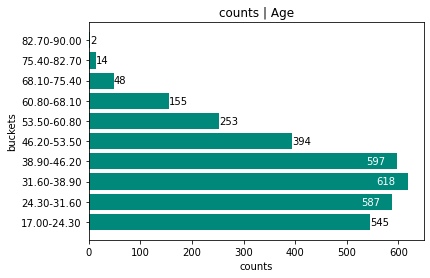
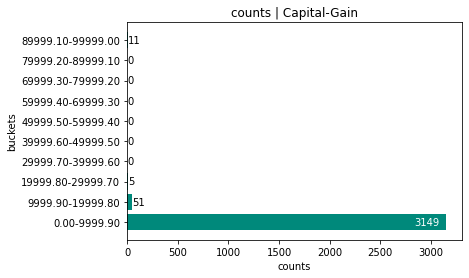
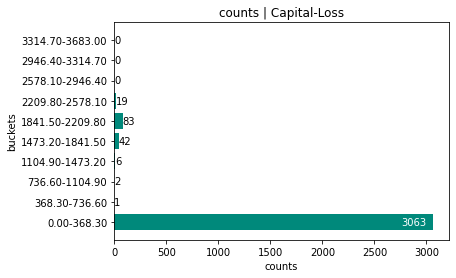
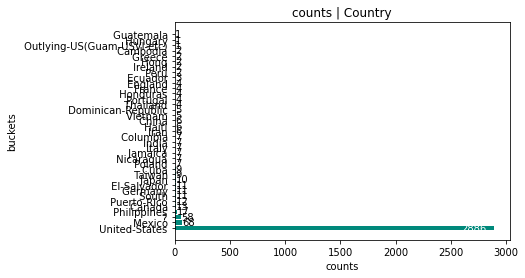
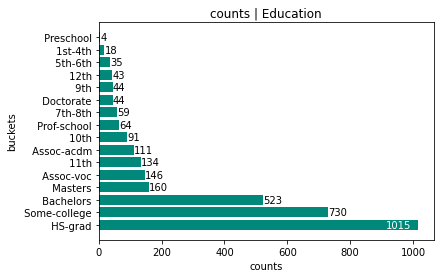
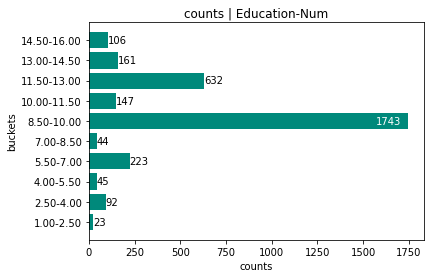
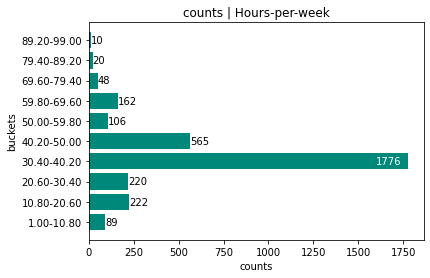
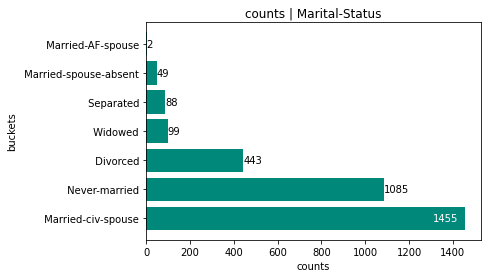
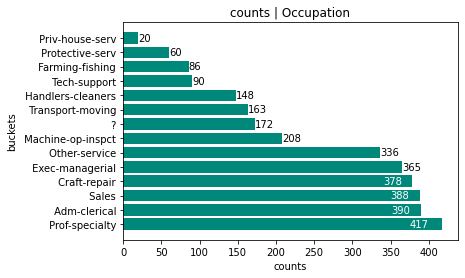
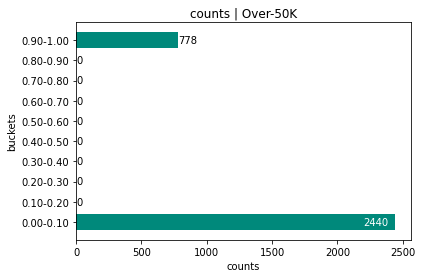
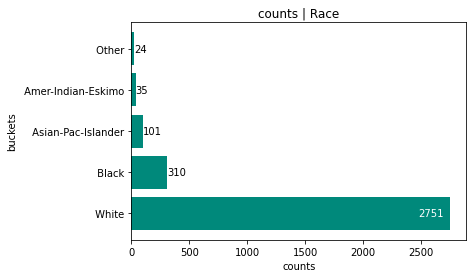
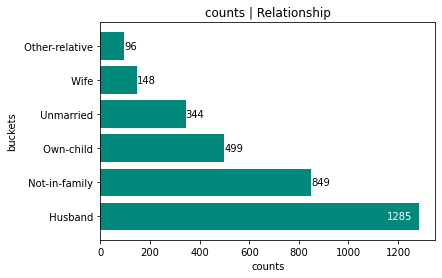
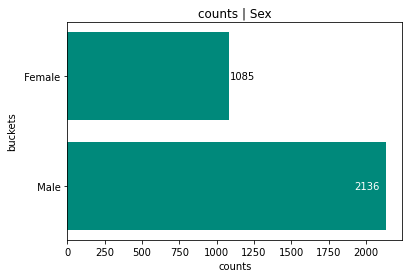
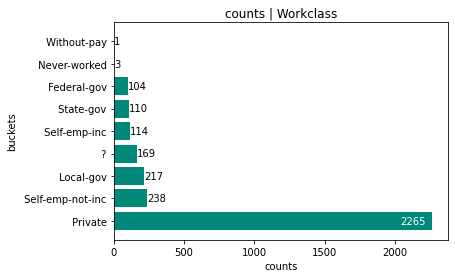
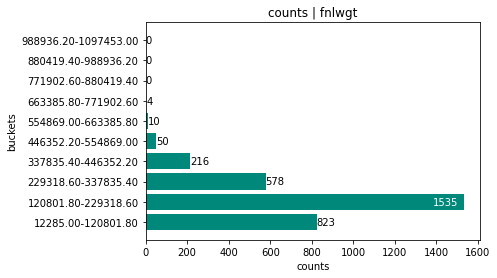
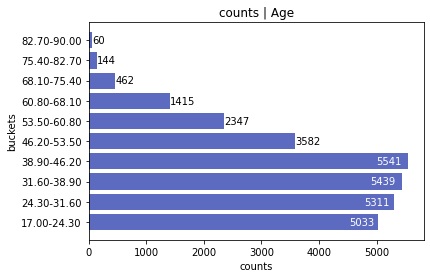
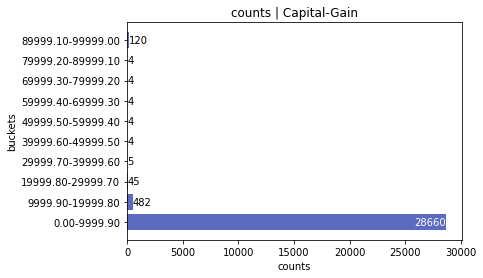
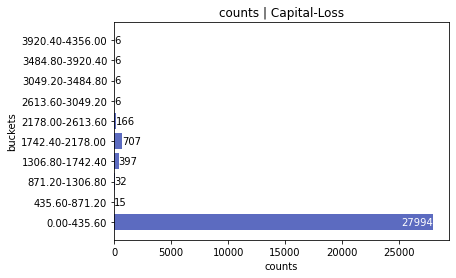
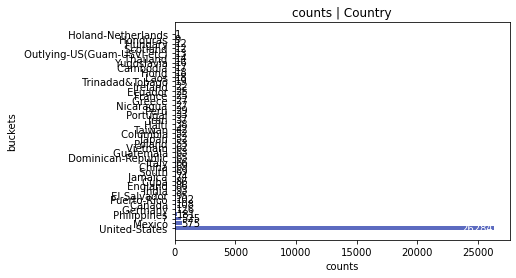
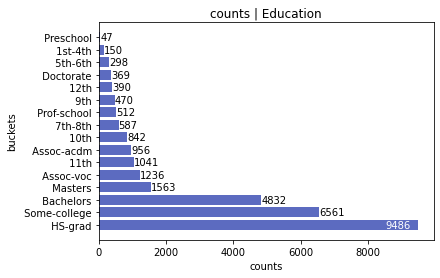
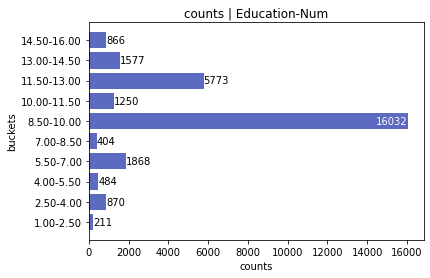
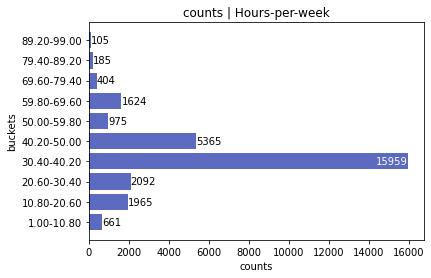
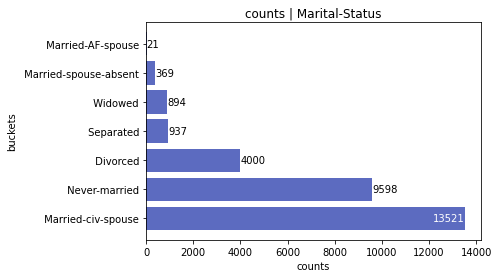
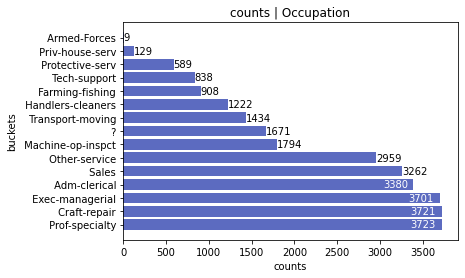
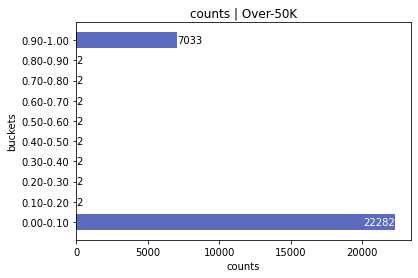
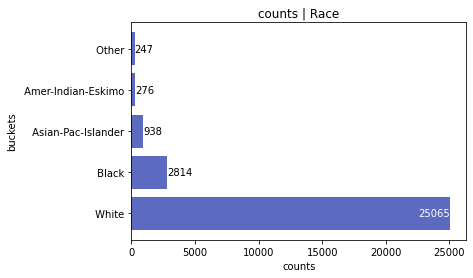
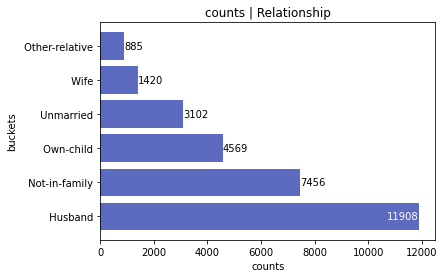
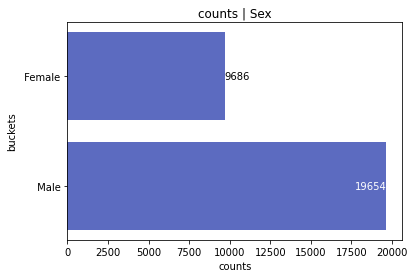
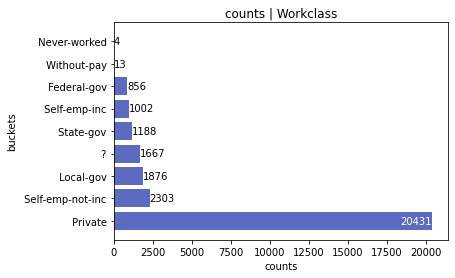
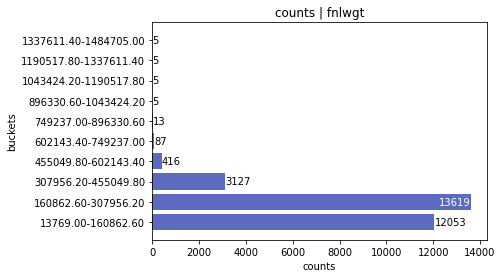
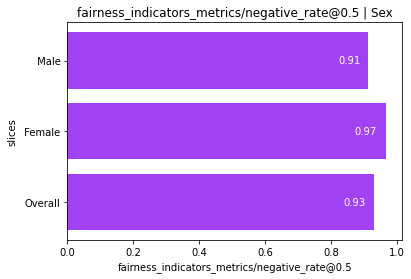
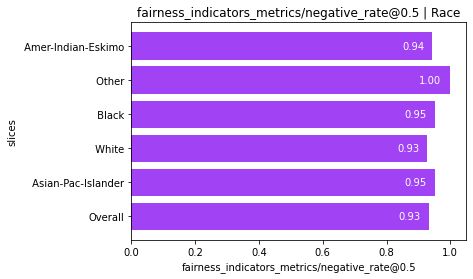
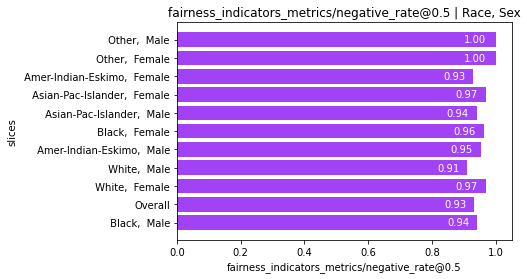
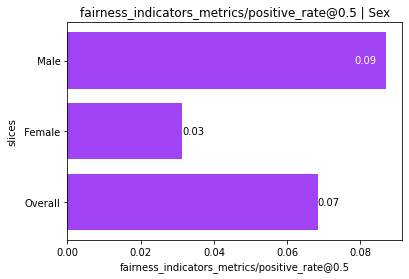
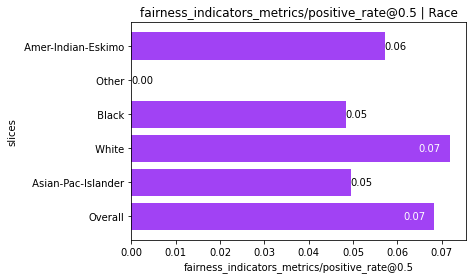
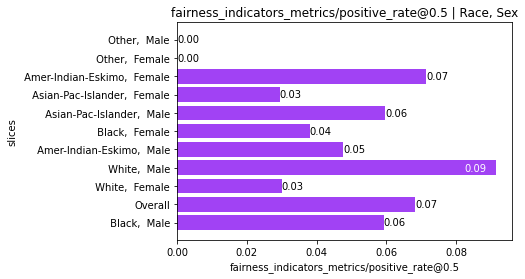
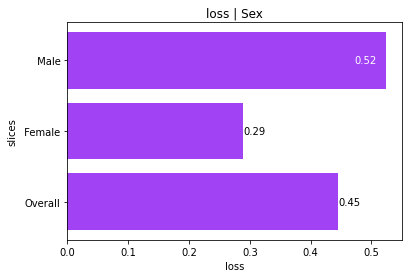
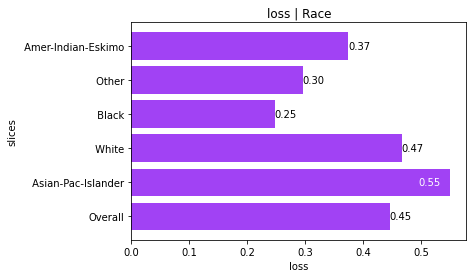
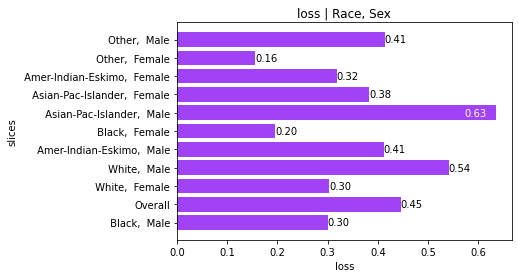
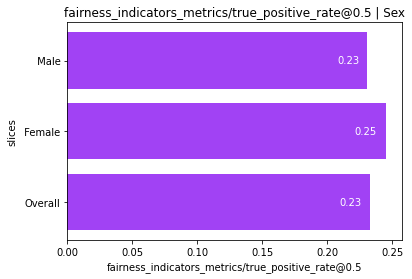
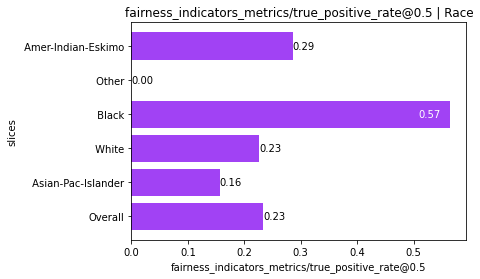
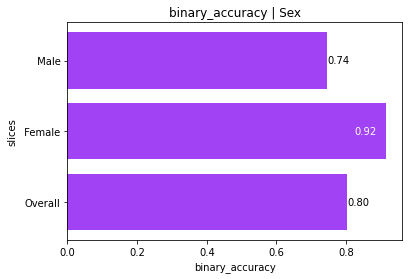
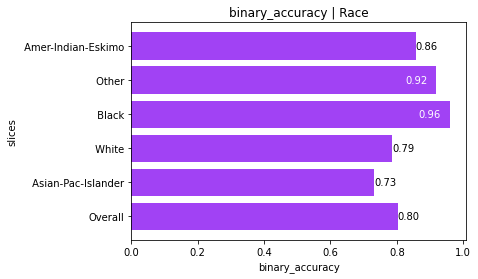
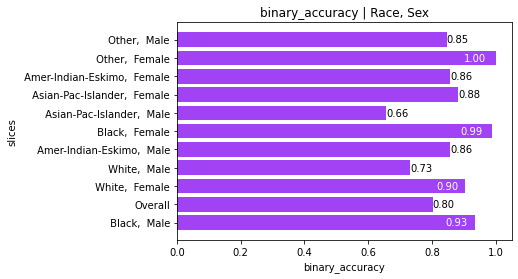
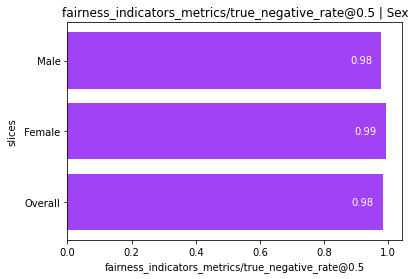
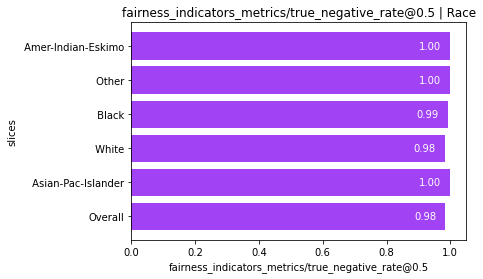
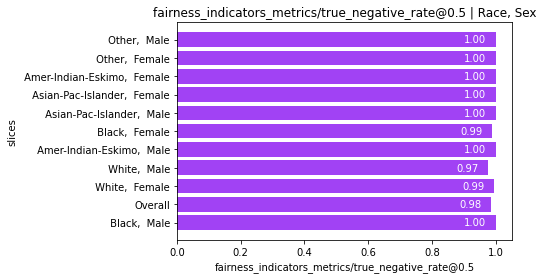
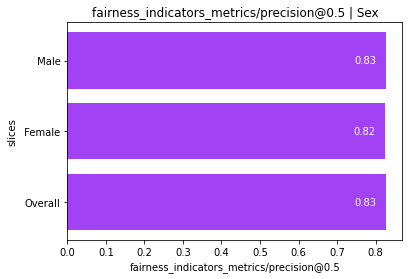
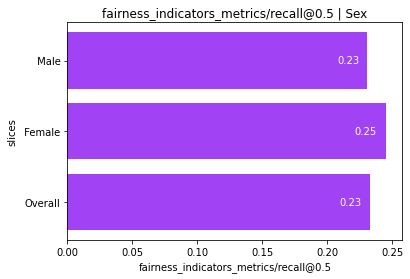
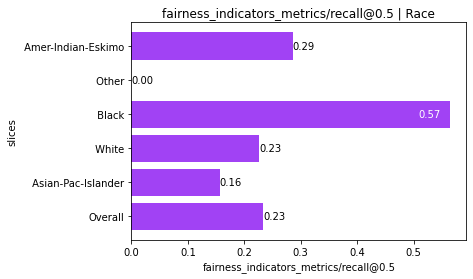
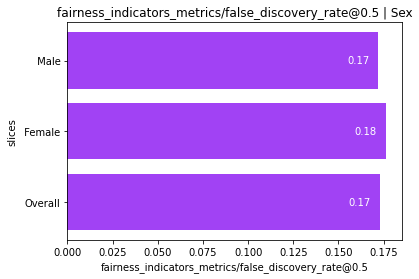
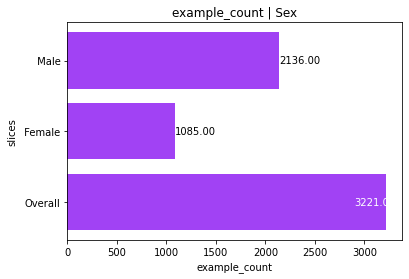
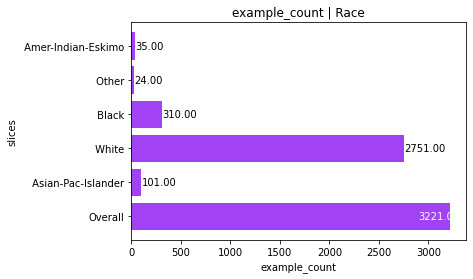
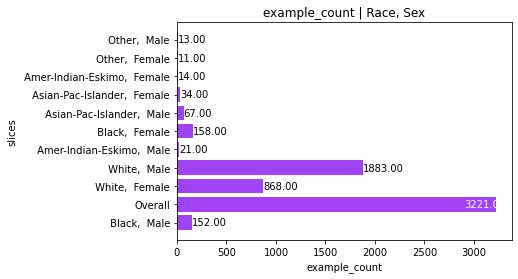
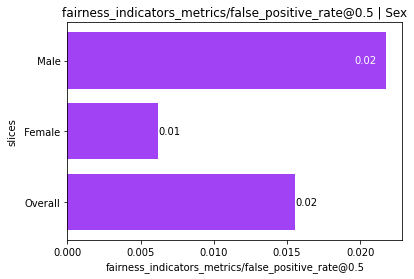
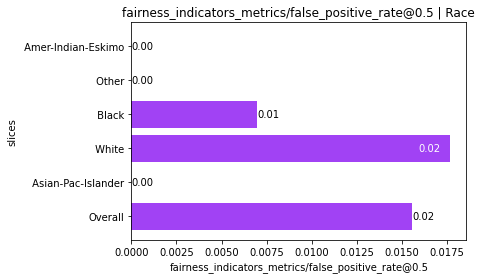
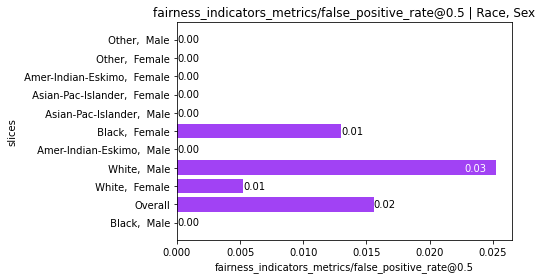
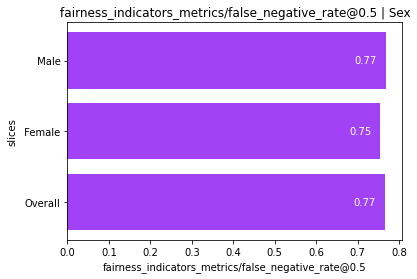
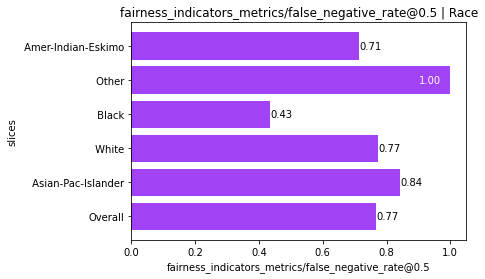
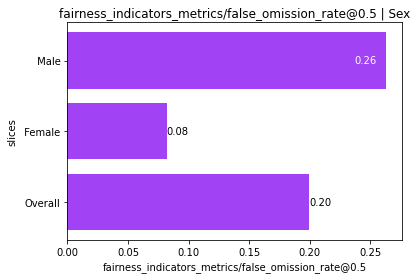
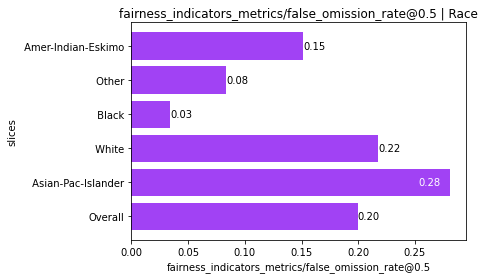
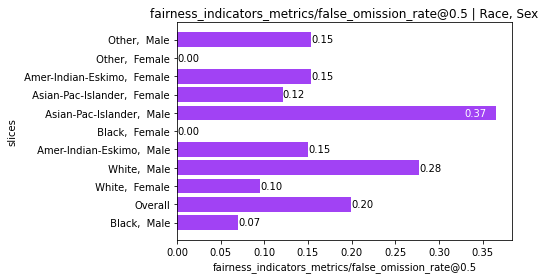

In [33]:
from IPython import display

mct_artifact = mct_gen.outputs['model_card'].get()[0]
mct_uri = mct_artifact.uri

print(os.listdir(mct_uri))

mct_path = os.path.join(mct_uri, 'model_cards', 'model_card.html')
with open(mct_path) as f:
  mct_content = f.read()


display.display(display.HTML(mct_content))